In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,Input,BatchNormalization

In [ ]:
def build_generator(gen_input,label,img_size) :
  img_resize = img_size//4
  kernel_size = 5
  layer_filters = [128,64,32,1]
  x = tf.keras.layers.concatenate([gen_input,label],axis=1)
  x = Dense(img_resize*img_resize*layer_filters[0])(x)
  x = tf.keras.layers.Reshape((img_resize,img_resize,layer_filters[0]))(x)
  for filters in layer_filters:
    if filters > layer_filters[-2] :
      strides= 2
    else :
      strides=1
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)
  x = tf.keras.layers.Activation('sigmoid')(x)
  generator_model = tf.keras.Model(inputs=[gen_input,label],outputs=x,name='generator_model')
  return generator_model

In [ ]:
def build_discriminator(dis_input,label,image_size) :
  kernel_size = 5
  layer_filters = [32,64,128,256]
  y = Dense(image_size*image_size)(label)
  y = tf.keras.layers.Reshape((image_size,image_size,1))(y)
  x = dis_input
  x = tf.keras.layers.concatenate([x,y])
  for filters in layer_filters :
    if filters == layer_filters[-1] :
      strides = 1
    else :
      strides = 2
    x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
    x = Conv2D(filters=filters,kernel_size=kernel_size,padding='same',strides=strides)(x)
  x = tf.keras.layers.Flatten()(x)
  x = Dense(1,activation='sigmoid')(x)
  discriminator_model = tf.keras.Model(inputs=[dis_input,label],outputs=x,name='discriminator_model')
  return discriminator_model

In [ ]:
(x_train,y_train) , (_,_) = tf.keras.datasets.mnist.load_data()
image_size = x_train.shape[1]
train_size = x_train.shape[0]
x_train = np.reshape(x_train,[-1,image_size,image_size,1]).astype('float')/255
y_train = tf.keras.utils.to_categorical(y_train)
num_categories =  10
latent_size = 100
batch_size = 64
train_steps = 10000
lr = 2e-4
decay = 6e-8
input_shape = (image_size,image_size,1)

#    build discrimator model

discriminator = build_discriminator(tf.keras.layers.Input(shape = input_shape),tf.keras.layers.Input(shape=(num_categories,)),image_size)
optimizer = tf.keras.optimizers.RMSprop(lr=lr,decay=decay)
discriminator.compile(loss ='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
discriminator.summary()
    
#    build generator model
input1 = tf.keras.layers.Input(shape = (latent_size,))
input2 = tf.keras.layers.Input(shape=(num_categories,))
generator = build_generator(tf.keras.layers.Input(shape = (latent_size,)),tf.keras.layers.Input(shape=(num_categories,)),image_size)

generator.summary()

#   build adversial model
    
optimizer = tf.keras.optimizers.RMSprop(lr=lr*0.5,decay=decay*0.5)

discriminator.trainable = False
adversial = tf.keras.Model(inputs=[input1,input2],outputs= discriminator([generator([input1,input2]),input2]),name = 'adversial_model')
adversial.compile(loss='binary_crossentropy',optimizer= optimizer,metrics=['accuracy'])
adversial.summary()

Model: "discriminator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 784)          8624        input_32[0][0]                   
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 28, 28, 1)    0           dense_18[0][0]                   
________________________________________________________________________________

In [ ]:
def train(models, data, params):
  generator, discriminator, adversarial = models
  x_train, y_train = data
  batch_size, latent_size, train_steps, num_categories =params
  train_size = x_train.shape[0]
  for i in range(train_steps):
    rand_indexes = np.random.randint(0, train_size,size=batch_size)
    real_images = x_train[rand_indexes]
    real_labels = y_train[rand_indexes]
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size,latent_size])
    fake_labels = np.eye(num_categories)[np.random.choice(num_categories,batch_size)]
    fake_images = generator.predict([noise, fake_labels])
    x = np.concatenate((real_images, fake_images))
    y_labels = np.concatenate((real_labels, fake_labels))
    y = np.ones([2 * batch_size, 1])
    y[batch_size:, :] = 0.0
    loss, acc = discriminator.train_on_batch([x, y_labels], y)
    log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size,latent_size])
    fake_labels = np.eye(num_categories)[np.random.choice(num_categories,batch_size)]
    y = np.ones([batch_size, 1])
    loss, acc = adversarial.train_on_batch([noise, fake_labels],y)
    log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
    print(log)

In [ ]:
models = generator,discriminator,adversial
params = batch_size, latent_size, train_steps, num_categories
data = x_train,y_train

In [ ]:
for _ in range(3) :
  train(models,data,params)

In [ ]:
model_json = generator.to_json()
with open("conditional_gan.json", "w") as json_file:
    json_file.write(model_json)
generator.save_weights("conditional_gan.h5")

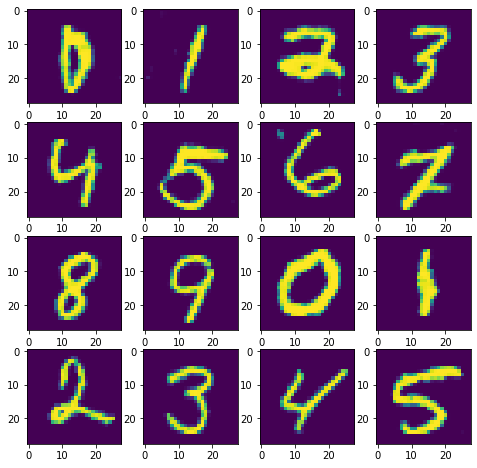

In [ ]:
fake_input = np.random.uniform(-1.0,1.0,size=[16,latent_size])
labels = np.eye(num_categories)[[i%10 for i in range(16)]]
fake_images = generator.predict([fake_input,labels])
fig = plt.figure(figsize=(8,8))
w=28
h=28
rows=4
columns=4
for i in range(1,columns*rows+1) :
  img = fake_images[i-1].reshape(28,28)
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
plt.show()